In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE
print("TensorFlow version {}".format(tf.__version__))
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version 2.7.0
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
!pip install -q h5py pyyaml

In [8]:
IMG_HEIGHT = 224
IMG_WIDTH = IMG_HEIGHT
CLASS_NAMES = 'Fire No-Fire'.split()

In [9]:
tfrecords_in_gcs = "gs://fire_detection_anurag/tfrecords/"

PATTERN_SUFFIX = '-*'

training_data_tfr = tfrecords_in_gcs  + "train" + PATTERN_SUFFIX
validation_data_tfr = tfrecords_in_gcs + "valid" + PATTERN_SUFFIX
test_data_tfr = tfrecords_in_gcs + "test" + PATTERN_SUFFIX

In [10]:
class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    
    def read_from_tfr(self, proto):
        feature_description = {
                                'image': tf.io.VarLenFeature(tf.float32),
                                'shape': tf.io.VarLenFeature(tf.int64),
                                'label': tf.io.FixedLenFeature([], tf.string,
                                                               default_value=''),
                                'label_int': tf.io.FixedLenFeature([], tf.int64,
                                                                   default_value=0),
                              }
        rec = tf.io.parse_single_example(
                                        proto,
                                        feature_description
                                        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    
    def read_from_jpegfile(self, filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img,
                                   channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
        
    def preprocess(self, img):
        return tf.image.resize_with_pad(img,
                                        IMG_HEIGHT,
                                        IMG_WIDTH)

In [11]:
# split the files into two halves and interleaves datasets
def create_preproc_dataset(pattern):
    """
    Does interleaving, parallel calls, prefetch, batching
    Caching is not a good idea on large datasets.
    """
    preproc = _Preprocessor()
    files = [filename for filename in tf.random.shuffle(tf.io.gfile.glob(pattern))]
    
    if len(files) > 1:
        print("Interleaving the reading of {} files.".format(len(files)))
        
        
        def _create_half_ds(x):
            if x == 0:
                half = files[:(len(files)//2)]
            else:
                half = files[(len(files)//2):]
                
            return tf.data.TFRecordDataset(half,
                                           compression_type='GZIP')
        
        
        ds = tf.data.Dataset.range(2).interleave(_create_half_ds,
                                                 num_parallel_calls=AUTOTUNE)
    else:
        ds = tf.data.TFRecordDataset(files,
                                     compression_type='GZIP')
        
        
    def _preproc_img_label(img, label):
        return (preproc.preprocess(img), label)
    
    
    ds = (ds
           .map(preproc.read_from_tfr,
                num_parallel_calls=AUTOTUNE)
           .map(_preproc_img_label,
                num_parallel_calls=AUTOTUNE)
           .shuffle(200)  # TODO
           .prefetch(AUTOTUNE)
         )
    
    return ds

In [12]:
train_dataset = create_preproc_dataset(
                                       training_data_tfr
                                      )

eval_dataset = create_preproc_dataset(
                                      validation_data_tfr
                                     )

test_dataset = create_preproc_dataset(
                                      test_data_tfr
                                      )

Interleaving the reading of 2 files.
Interleaving the reading of 2 files.
Interleaving the reading of 2 files.


In [13]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

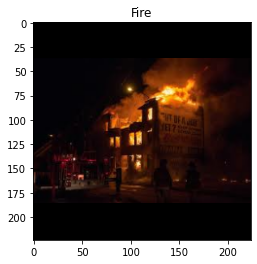

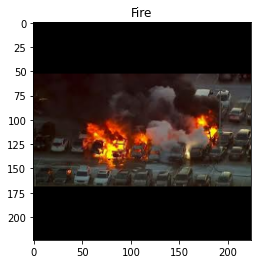

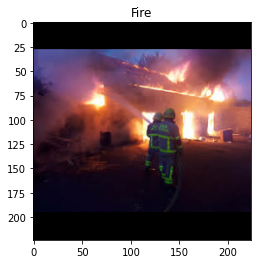

In [14]:
for image, label in train_dataset.take(3):
    plt.figure()
    plt.imshow(image)
    # print(CLASS_NAMES[label.numpy()])
    plt.title(CLASS_NAMES[label.numpy()])

In [54]:
IMG_SIZE = IMG_HEIGHT # All images will be resized to 224 x 224

def format_image(image, label):
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    return  image, label

In [55]:
train = train_dataset.map(format_image)
validation = eval_dataset.map(format_image)
test = test_dataset.map(format_image)

In [56]:
BATCH_SIZE = 16

In [57]:
train_batches = train.batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [58]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([16, 224, 224, 3])

In [59]:
label_batch

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1])>

In [60]:
label_batch.numpy()

array([1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1])

In [61]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [62]:
base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [63]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1280)


In [64]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


In [65]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 2)


In [66]:
model = tf.keras.Sequential([
                            base_model,
                            global_average_layer,
                            prediction_layer
                            ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [67]:
# callbacks
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
                                                         filepath='./chkpts',
                                                         monitor='val_accuracy',
                                                         mode='max',
                                                         save_best_only=True
                                                        )

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
                                                     monitor='val_accuracy',
                                                     mode='max',
                                                     patience=5
                                                    )

In [68]:
lrate = 0.02

model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=lrate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                                                                 from_logits=False
                                                                ),
              metrics=['accuracy']
             )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [69]:
len(model.trainable_variables)

2

In [70]:
EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[
                               model_checkpoint_cb,
                               early_stopping_cb,
                              ],
                    verbose=1)

Epoch 1/20
    114/Unknown - 18s 124ms/step - loss: 0.7793 - accuracy: 0.8887

INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


115/115 [==============================] - 55s 444ms/step - loss: 0.7767 - accuracy: 0.8886 - val_loss: 0.3085 - val_accuracy: 0.9386


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/20
115/115 [==============================] - 18s 145ms/step - loss: 0.2695 - accuracy: 0.9429 - val_loss: 0.4115 - val_accuracy: 0.9355
Epoch 3/20
115/115 [==============================] - 19s 153ms/step - loss: 0.2213 - accuracy: 0.9533 - val_loss: 0.5036 - val_accuracy: 0.9324
Epoch 4/20
115/115 [==============================] - 18s 146ms/step - loss: 0.2773 - accuracy: 0.9533 - val_loss: 0.5828 - val_accuracy: 0.9324
Epoch 5/20
115/115 [==============================] - 18s 148ms/step - loss: 0.1553 - accuracy: 0.9701 - val_loss: 0.4920 - val_accuracy: 0.9339
Epoch 6/20
115/115 [==============================] - ETA: 0s - loss: 0.1033 - accuracy: 0.9788

INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


115/115 [==============================] - 48s 407ms/step - loss: 0.1033 - accuracy: 0.9788 - val_loss: 0.4838 - val_accuracy: 0.9447


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7/20
115/115 [==============================] - 20s 162ms/step - loss: 0.1950 - accuracy: 0.9641 - val_loss: 0.6175 - val_accuracy: 0.9324
Epoch 8/20
115/115 [==============================] - 19s 151ms/step - loss: 0.0482 - accuracy: 0.9848 - val_loss: 0.6366 - val_accuracy: 0.9324
Epoch 9/20
115/115 [==============================] - 18s 147ms/step - loss: 0.0502 - accuracy: 0.9875 - val_loss: 0.5508 - val_accuracy: 0.9401
Epoch 10/20
115/115 [==============================] - 18s 149ms/step - loss: 0.0896 - accuracy: 0.9804 - val_loss: 0.8470 - val_accuracy: 0.9247
Epoch 11/20
115/115 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.9859

INFO:tensorflow:Assets written to: ./chkpts/assets


INFO:tensorflow:Assets written to: ./chkpts/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


115/115 [==============================] - 49s 415ms/step - loss: 0.0770 - accuracy: 0.9859 - val_loss: 0.4748 - val_accuracy: 0.9478


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 12/20
115/115 [==============================] - 18s 148ms/step - loss: 0.1134 - accuracy: 0.9837 - val_loss: 0.5687 - val_accuracy: 0.9447
Epoch 13/20
115/115 [==============================] - 19s 150ms/step - loss: 0.1332 - accuracy: 0.9826 - val_loss: 0.6672 - val_accuracy: 0.9370
Epoch 14/20
115/115 [==============================] - 19s 151ms/step - loss: 0.0989 - accuracy: 0.9815 - val_loss: 0.8639 - val_accuracy: 0.9432
Epoch 15/20
115/115 [==============================] - 21s 168ms/step - loss: 0.1111 - accuracy: 0.9826 - val_loss: 0.8442 - val_accuracy: 0.9370
Epoch 16/20
115/115 [==============================] - 18s 148ms/step - loss: 0.0407 - accuracy: 0.9902 - val_loss: 0.8435 - val_accuracy: 0.9432


In [71]:
class_names = np.array(CLASS_NAMES)

class_names

array(['Fire', 'No-Fire'], dtype='<U7')

In [72]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
print(predicted_ids)

predicted_class_names = class_names[predicted_ids]
predicted_class_names

[1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1]


array(['No-Fire', 'No-Fire', 'No-Fire', 'Fire', 'Fire', 'No-Fire',
       'No-Fire', 'Fire', 'Fire', 'Fire', 'No-Fire', 'No-Fire', 'No-Fire',
       'No-Fire', 'Fire', 'No-Fire'], dtype='<U7')

In [73]:
print("Actual Labels   : ", label_batch.numpy())
print("Predicted labels: ", predicted_ids)

Actual Labels   :  [1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1]
Predicted labels:  [1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1]


In [74]:
# image_batch[0].numpy()

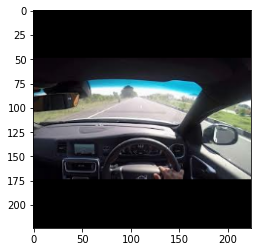

In [75]:
plt.imshow(image_batch[2].numpy())

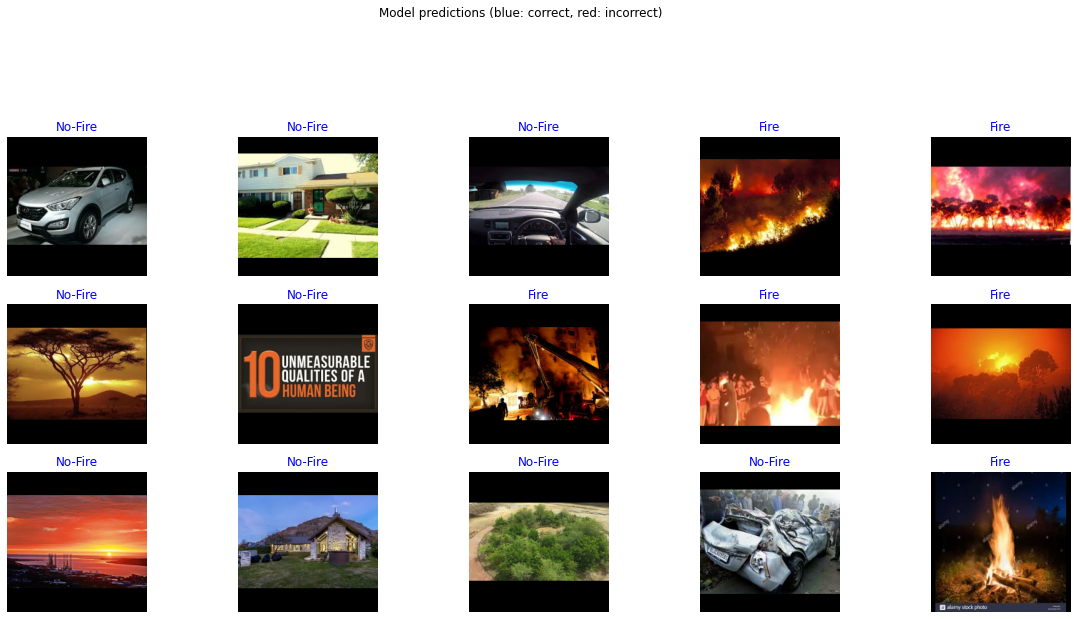

In [76]:
plt.figure(figsize=(20, 18))
for n in range(15):
    plt.subplot(6, 5, n + 1)
    plt.imshow(image_batch[n].numpy())
    
    #print(predicted_ids[n], label_batch[n].numpy())
    if predicted_ids[n] == label_batch[n].numpy():
        color = 'blue'
    else:
        color = 'red'

    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
i = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

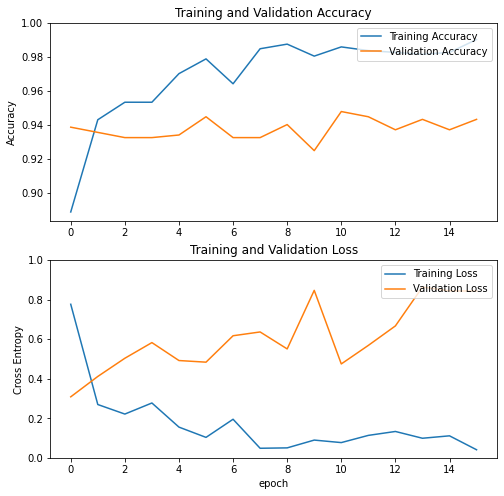

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# !pip install -q h5py pyyaml

In [78]:
transfer_learn_model = 'transfer_learning_model.h5'
model.save(transfer_learn_model)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [79]:
new_model = tf.keras.models.load_model(transfer_learn_model)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [80]:
tflite_transfer_model = "transfer_model.tflite"

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

open(tflite_transfer_model, "wb").write(tflite_model)

print('The model has been successfully converted and stored')

INFO:tensorflow:Assets written to: /tmp/tmp2tatx7u3/assets


INFO:tensorflow:Assets written to: /tmp/tmp2tatx7u3/assets


The model has been successfully converted and stored


In [81]:
with open('Fire_detector_labels.txt', 'w') as f:
  f.write('Fire\nNo-Fire')